# Train Code

## 実行環境のセットアップ
コードの実行に必要な環境のセットアップ

### Settings
機械学習に必要な各種パラメータを設定

In [4]:
from pytorch_lightning.callbacks import ModelCheckpoint

In [5]:
!pip install python-gdcm
!pip install pylibjpeg pylibjpeg-libjpeg pydicom
!pip install -qU "python-gdcm" pydicom pylibjpeg "opencv-python-headless"
!pip install monai

In [6]:
# Common Settings

# 学習者氏名
TRAINER = "yamaday"
# エポック数
NUM_EPOCH = 10
CLASS_NUM = 13
# GCP のプロジェクトID
GCP_PROJECT_ID = "ai-facade"
# GCS のバケット名
GCS_BUCKET_NAME = "ai-facade-competitions"

# コンペのプロジェクトID
CEREBRUM_PROJECT_ID = "202208_cervical_spine_fracture_detection"

In [7]:
# DEV RUN

# Trainer の開発モード指定
#   - False: Trainer を本番モードで運用
#   - True : Trainer を開発モードで運用（1ステップで終了）
#   - (int): Trainer を開発モードで運用（任意のステップ数を実行して終了）
FAST_DEV_RUN = False

# 開発用のデータ削減
#   - False: データ数を削減しない
#   - (int): 指定した数までデータ数を削減
DEV_DATA_SIZE = False

# for debug: (https://qiita.com/makopo/items/170c939c79dcc5c89e12)
# from IPython.core.debugger import Pdb; Pdb().set_trace()

In [8]:
# Training Settings

MODEL_OPTION = {
    "model": {
        "name": "baseline/segmentation/Unet",
        "params": {
            "base.model": "Unet",
            "fc.model": ""
        }
    },
    "optimizer": {
        "name": "AdamW",
        "params": {
            "model.lr": 2e-3,
            "weight_decay": 1e-6,
            "eps": 1e-6,
        }
    },
    "scheduler": {
        "name": "transformer_cosine",
        "params": {
            "num_warmup_steps": 0,
            "num_cycles": 0.5
        }
    },
    "criterion": {
        "name": ["BCEWithLogitsLoss"],
        "params": {
            "reduction": "none"
        }
    }
}

DATASET_OPTION = {
    "source": "original",
    "train_test_split": [],
    "train_valid_split": [],
}

TRAINING_OPTION = {
    "batch_size": 4,
    "custom": {
        "dev_run": FAST_DEV_RUN,
        "dev_data_size": DEV_DATA_SIZE,
        "n_split": 5,
        "target_fold": [0],
#         "target_fold": list(range(0, 5)),
        "fold_method": "StratifiedGroupKFold",
        "early_stopping": False,
        "save_each_model": False,
        "save_best_loss_model": True,
        "save_best_score_model": True,
        "auto_scale_batch_size": False,
        "auto_lr_find": True,
        "image_size": 224,
        "transforms": True,
    }
}

ENVIRONMENT_OPTION = {
    "random_seed": 42,
    "custom": {
        "apex": False
    }
}

### Setup
ライブラリのインポート、グローバル変数の定義

In [9]:
!pip uninstall -y pytorch-lightning
!pip install pytorch-lightning==1.6.4
!pip install segmentation-models-pytorch==0.2.1

import os
import sys
import gc
import itertools
import platform
import datetime
import logging
import ast
import zipfile
import warnings
import pandas as pd
import numpy as np
from copy import deepcopy
from pytz import timezone, utc
from glob import glob
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from PIL import Image
import cv2
import random
from tqdm import tqdm
tqdm.pandas()
import pydicom
from matplotlib import pyplot as plt
import re

# sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold, GroupKFold
from sklearn.metrics import f1_score
from scipy.spatial.distance import directed_hausdorff

# segmentation-models-pytorch
import segmentation_models_pytorch as smp
import monai
from monai.data import CSVDataset
from monai.data import DataLoader
import nibabel as nib

# torch
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn import preprocessing

import albumentations as A
import torch.nn.functional as F

import segmentation_models_pytorch as smp

from transformers import (
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
    get_cosine_with_hard_restarts_schedule_with_warmup
)

# pytorch-lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# google cloud plotform
from google.cloud import storage

warnings.simplefilter('ignore')

os.environ["TOKENIZERS_PARALLELISM"] = "false"

print("-" * 20)
print(f"pytorch_lightning version: {pl.__version__}")
print(f"smp version: {pl.__version__}")

Found existing installation: pytorch-lightning 1.6.4
Uninstalling pytorch-lightning-1.6.4:
  Successfully uninstalled pytorch-lightning-1.6.4
  Using cached pytorch_lightning-1.6.4-py3-none-any.whl (585 kB)
--------------------
pytorch_lightning version: 1.6.4
smp version: 1.6.4


In [10]:
# task
TASK = "semantic-segmentation-3D"

# idf path
LOCAL_IDF_PATH = "models/{model_id}/fold{fold}.idf.json"
GCS_IDF_PATH = "models/{task}/{model_name}/{model_id}{dev_mode}/fold{fold}.idf.json"

# model path
LOCAL_MODEL_PATH = "models/{model_id}/fold-{fold}/generation-{generation}.ckpt"
GCS_MODEL_PATH = "models/{task}/{model_name}/{model_id}{dev_mode}/fold-{fold}/generation-{generation}.ckpt"

LOCAL_BEST_MODEL_PATH = "models/{model_id}/fold-{fold}/"
GCS_BEST_MODEL_PATH = "models/{task}/{model_name}/{model_id}{dev_mode}/fold-{fold}/{filename}"

In [11]:
# logger

def cvt_jst_time(*args):
    utc_dt = utc.localize(datetime.datetime.utcnow())
    jst_tz = timezone("Asia/Tokyo")
    converted = utc_dt.astimezone(jst_tz)
    return converted.timetuple()


def get_logger():
    formatter = logging.Formatter(
        fmt="%(asctime)s [%(levelname)s] %(message)s",
        datefmt="%Y-%m-%d %H:%M:%S"
    )
    formatter.converter = cvt_jst_time
    
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    
    handler = logging.StreamHandler(sys.stdout)
    handler.setLevel(logging.INFO)
    handler.setFormatter(formatter)
    
    logger.addHandler(handler)
    
    return logger


try:
    logger
except NameError:
    logger = get_logger()

In [12]:
# Import Cerebrum Connector

CC_PACKAGE_NAME = "CerebrumConnector.zip"

def download_cc_package():
    logger.info("start: download cc package")
    gcs_client = storage.Client(project=GCP_PROJECT_ID)
    bucket = gcs_client.bucket(GCS_BUCKET_NAME)
    blob = bucket.blob(CC_PACKAGE_NAME)
    blob.download_to_filename(CC_PACKAGE_NAME)
    logger.info("complete: download cc package")


def unzip_package():
    logger.info("start: unzip cc package")
    with zipfile.ZipFile(CC_PACKAGE_NAME) as zf:
        zf.extractall()
    logger.info("complete: unzip cc package")


if not os.path.exists(CC_PACKAGE_NAME):
    download_cc_package()
    unzip_package()

from CerebrumConnector import CerebrumConnector as cc
from CerebrumConnector import GoogleCloudPlatform as cc_gcp

In [13]:
# Setup Cerebrum Connector

def get_identification():
    idf = cc.Identification(
        cerebrum_project_id=CEREBRUM_PROJECT_ID,
        trainer=TRAINER,
        task=TASK,
        model_name=MODEL_OPTION["model"]["name"]
    )
    return idf


def get_gcs_connector():
    gcs_connector = cc_gcp.GCSConnector(
        gcp_project_name=GCP_PROJECT_ID,
        bucket_name=GCS_BUCKET_NAME,
        sub_dir=CEREBRUM_PROJECT_ID
    )
    return gcs_connector


def set_options_to_identification(idf):
    model_option = cc.ModelOption(
        model=cc.ModelOptionItem(**MODEL_OPTION["model"]),
        optimizer=cc.ModelOptionItem(**MODEL_OPTION["optimizer"]),
        scheduler=cc.ModelOptionItem(**MODEL_OPTION["scheduler"]),
        criterion=cc.ModelOptionItem(**MODEL_OPTION["criterion"])
    )
    dataset_option = cc.DatasetOption(**DATASET_OPTION)
    training_option = cc.TrainingOption(**TRAINING_OPTION)
    environment_option = cc.EnvironmentOption(**ENVIRONMENT_OPTION)
    
    idf.set_options(
        model_option,
        dataset_option,
        training_option,
        environment_option
    )


idf = get_identification()
set_options_to_identification(idf)

gcs_connector = get_gcs_connector()

In [14]:
# set random seed

def set_seed(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(idf.environment_option.random_seed)

## Preprocessing
機械学習の前処理

In [15]:
seg_image_paths = glob(os.path.join('../input/rsna-2022-cervical-spine-fracture-detection/segmentations', "*"))

seg_image_uids = pd.DataFrame([f"{os.path.splitext(os.path.basename(path))[0]}" for path in seg_image_paths]
, columns=["StudyInstanceUID"])

_train_df = pd.read_csv('../input/rsna-2022-cervical-spine-fracture-detection/train.csv')
train_bounding_boxes_df = pd.read_csv('../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv')
_train_df = _train_df.merge(seg_image_uids, on=['StudyInstanceUID'], how='inner')

In [16]:
_train_df

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
1,1.2.826.0.1.3680043.25704,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.20647,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.31077,1,0,0,1,1,1,1,0
4,1.2.826.0.1.3680043.17960,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
82,1.2.826.0.1.3680043.32071,1,0,1,0,1,0,1,1
83,1.2.826.0.1.3680043.30524,1,0,0,0,0,0,1,1
84,1.2.826.0.1.3680043.28025,0,0,0,0,0,0,0,0
85,1.2.826.0.1.3680043.21321,1,1,1,1,0,0,0,1


In [17]:
def get_path(row):
    image_paths = glob(os.path.join(f'../input/rsna-2022-cervical-spine-fracture-detection/train_images/{row["StudyInstanceUID"]}', "*.dcm"))
    p = re.compile(r'(\d+).dcm')
    image_paths.sort(key=lambda s: int(p.search(s).groups()[0]))
    
    if len(image_paths) < idf.training_option.custom['image_size']:
        ins = ["" for i in range(idf.training_option.custom['image_size'] - len(image_paths))]
        image_paths.extend(ins)
    row['image_paths'] = image_paths[:idf.training_option.custom['image_size']]
    row['mask_path'] = f"../input/rsna-2022-cervical-spine-fracture-detection/segmentations/{row['StudyInstanceUID']}.nii"
    row['image_length'] = len(image_paths)
    return row

_train_df = _train_df.progress_apply(get_path, axis=1)

100%|██████████| 87/87 [00:02<00:00, 42.58it/s]


<AxesSubplot:>

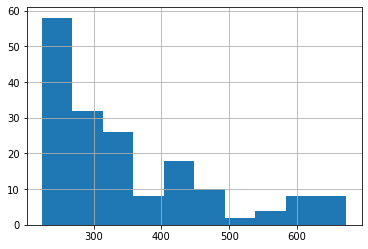

In [18]:
_train_df['image_length'].hist()

In [19]:
_train_df[_train_df["StudyInstanceUID"] == "1.2.826.0.1.3680043.21321"]["image_paths"]

170    [../input/rsna-2022-cervical-spine-fracture-de...
171    [../input/rsna-2022-cervical-spine-fracture-de...
Name: image_paths, dtype: object

In [20]:
mm = preprocessing.MinMaxScaler()

def read_dcm_file(file_path):
    image_size = (idf.training_option.custom['image_size'], idf.training_option.custom['image_size'])
    
    if not file_path:
        img = np.zeros(image_size, dtype=np.float32)
    else:
        img =  pydicom.read_file(file_path).pixel_array
        img =  mm.fit_transform(img) * 255.0 
        img = cv2.resize(img, image_size)
    img = np.tile(img[...,None], [1, 1, 1]) 
    img = img / 255

    return img

def read_mask(file_path):
    image_size = (idf.training_option.custom['image_size'], idf.training_option.custom['image_size'])
    nii = nib.load(file_path)
    nii_arrays = nii.get_fdata()  # convert to numpy array
    
    mask = nii_arrays[:, :, :idf.training_option.custom['image_size']]
    if mask.shape[2] < idf.training_option.custom['image_size']:
        ins = np.zeros((mask.shape[0], mask.shape[1], idf.training_option.custom['image_size'] - mask.shape[2]), dtype=np.float32)
        mask = np.concatenate([mask, ins], axis=2)

    mask = mask / CLASS_NUM
    mask = cv2.resize(mask, image_size).transpose(2, 1, 0)
    mask = np.tile(mask[...,None], [1, 1, 1]) # gray to rgb

    return mask

In [21]:
p = read_dcm_file("../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.20928/80.dcm")

In [22]:
imgs_ex = []
for img_path in _train_df.iloc[0]['image_paths']:
    imgs_ex.append(read_dcm_file(img_path))

mask_path = _train_df.iloc[0]['mask_path']
masks = read_mask(mask_path)

In [23]:
imgs_ex[1].shape

(224, 224, 1)

In [24]:
masks.shape

(224, 224, 224, 1)

## Training
機械学習を実行

### データを分割

In [25]:
# split dataset (k-fold)

def k_fold(idf, raw_df):
    df = raw_df.copy()
    n_splits = idf.training_option.custom["n_split"]
    if idf.training_option.custom["fold_method"] == "StratifiedGroupKFold":
        skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True)
        for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df['patient_overall'], groups=df['StudyInstanceUID'])):
            df.loc[val_idx, 'fold'] = int(fold)
    df['fold'] = df['fold'].astype(np.uint8)
    return df

# 開発用のデータ削減
if DEV_DATA_SIZE:
    logger.info(f"DEV_MODE: data size: {len(_train_df)} -> {DEV_DATA_SIZE}")
    _train_df = _train_df[:DEV_DATA_SIZE]
    
_train_df = k_fold(idf, _train_df)
logger.info("split dataset. size: {}".format(_train_df.groupby("fold").size().to_dict()))

gc.collect()


2022-09-21 14:07:50 [INFO] split dataset. size: {0: 36, 1: 36, 2: 34, 3: 34, 4: 34}


0

### Dataset

In [26]:
from sklearn import preprocessing
mm = preprocessing.MinMaxScaler()

class CustomDataset(Dataset):
    def __init__(self, idf, df, transforms=None):
        self.idf = idf
        self.df = df
        self.img_paths  = df['image_paths'].tolist()
        self.mask_paths  = df['mask_path'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_paths  = self.img_paths[index]
        imgs = []
        for img_path in img_paths:
            imgs.append(self._read_dcm_file(img_path))
        
        mask_path = self.mask_paths[index]
        masks = self._read_mask(mask_path)
        
        if self.transforms is not None:
            imgs = np.array(imgs, dtype=np.float32)
            aug = self.transforms(image=imgs, mask=masks)
            imgs = aug['image']
            masks = aug['mask']
        
        imgs = np.array(imgs, dtype=np.float32)
        imgs = imgs.transpose(3, 1, 2, 0)
        masks = masks.transpose(3, 1, 2, 0)

        return torch.tensor(imgs, dtype=torch.float), torch.tensor(masks, dtype=torch.float)
    
    def _read_dcm_file(self, file_path):
        image_size = (self.idf.training_option.custom['image_size'], self.idf.training_option.custom['image_size'])
        if not file_path:
            img = np.zeros(image_size, dtype=np.float16)
        else:
            img =  pydicom.read_file(file_path).pixel_array
            img =  mm.fit_transform(img) * 255.0 
            img = cv2.resize(img, image_size)
        img = np.tile(img[...,None], [1, 1, 1]) 
        img = img / 255

        return img

    def _read_mask(self, file_path):
        image_size = (self.idf.training_option.custom['image_size'], self.idf.training_option.custom['image_size'])
        nii = nib.load(file_path)
        nii_arrays = nii.get_fdata()  # convert to numpy array
        mask = nii_arrays[:, :, :self.idf.training_option.custom['image_size']]
        if mask.shape[2] < idf.training_option.custom['image_size']:
            ins = np.zeros((mask.shape[0], mask.shape[1], self.idf.training_option.custom['image_size'] - mask.shape[2]), dtype=np.float16)
            mask = np.concatenate([mask, ins], axis=2)
    
        mask = mask / CLASS_NUM
        mask = cv2.resize(mask, image_size).transpose(2, 1, 0)
        mask = np.tile(mask[...,None], [1, 1, 1]) # gray to rgb

        return mask

### DataModule

In [27]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, idf, train_df, valid_df, transforms=None):
        super().__init__()
        
        self.idf = idf
        self.train_df = train_df
        self.valid_df = valid_df
        self.train_transforms = transforms['train'] if transforms != None else None
        self.valid_transforms = transforms['valid'] if transforms != None else None   
        
    def train_dataloader(self):
        dataset = CustomDataset(self.idf, self.train_df, self.train_transforms)
        data_loader = DataLoader(
            dataset,
            batch_size=self.idf.training_option.batch_size,
            shuffle=True,
            num_workers=os.cpu_count(),
            pin_memory=True,
            drop_last=True
        )
        return data_loader
    
    def val_dataloader(self):
        dataset = CustomDataset(self.idf, self.valid_df, self.valid_transforms)
        data_loader = DataLoader(
            dataset,
            batch_size=self.idf.training_option.batch_size,
            shuffle=False,
            num_workers=os.cpu_count(),
            pin_memory=True,
            drop_last=True
        )
        return data_loader

### transforms

In [28]:
data_transforms =  {
    "train": A.Compose([
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.OneOf([
            A.RandomContrast(),
            A.RandomGamma(),
            A.RandomBrightness(),
        ], p=0.5),
    ], p=1.0),
    "valid": None} if idf.training_option.custom["transforms"] else None

### Scoring functions

In [29]:
# Scoring functions
class ScoringFn():
    @classmethod
    def scoring(cls, pred, label):
        """ スコアリング """
        score = F.binary_cross_entropy_with_logits(pred, label)
        return score


### Optimizer & Scheduler

In [30]:
# Optimizer Utilities

class OptimizerUtils():
    @staticmethod
    def get_optimizer(idf, model, lr):
        """ optimizer を取得 """
        optimizer_name = idf.model_option.optimizer.name
        optimizer_params = idf.model_option.optimizer.params

        if optimizer_name == "AdamW":
            return AdamW(model.parameters(), 
                         lr=lr,
                         eps=optimizer_params["eps"], 
                         weight_decay=optimizer_params["weight_decay"])
        else:
            raise Exception(f"optimizer: {optimizer_name} is not supported.")
    
    @staticmethod
    def get_scheduler(idf, optimizer, num_training_steps, train_dl_size):
        """ scheduler を取得 """
        scheduler_name = idf.model_option.scheduler.name
        scheduler_params = idf.model_option.scheduler.params
        
        if scheduler_params["num_warmup_steps"] == "first_epoch":
            scheduler_params["num_warmup_steps"] = train_dl_size
        
        if scheduler_name == "transformer_cosine":
            return get_cosine_schedule_with_warmup(
                optimizer,
                num_training_steps=num_training_steps,
                **scheduler_params
            )
        
        elif scheduler_name == "transformer_cosine_with_hard_restarts":
            return get_cosine_with_hard_restarts_schedule_with_warmup(
                optimizer,
                num_training_steps=num_training_steps,
                **scheduler_params
            )
        
        elif scheduler_name == "transformer_linear":
            return get_linear_schedule_with_warmup(
                optimizer,
                num_training_steps=num_training_steps,
                **scheduler_params
            )

        else:
            raise Exception(f"scheduler: {scheduler_name} is not supported.") 

### Criterion

In [31]:
# Criterion Utilities

class CriterionUtils():
    @staticmethod
    def get_criterion(criterion_name, criterion_params):
        """ criterion を取得 """
        if criterion_name == "BCEWithLogitsLoss":
            return nn.BCEWithLogitsLoss(**criterion_params)
        else:
            raise Exception(f"criterion: {criterion_name} is not supported.") 

### Model

In [32]:
# Inner Model

class InnerModel(nn.Module):
    def __init__(self, idf):
        super().__init__()
        self.idf = idf
        # model config
        base_model_name = idf.model_option.model.params["base.model"]
        self.model = self.__build_base_model(base_model_name)
        self.fc = nn.Sequential(nn.ReLU())
        
    def forward(self, inputs):
        output = self.model(inputs)
        output = self.fc(output)
        
        return output
    
    def __build_base_model(self, base_model_name):
        if base_model_name == "Unet":
            return monai.networks.nets.UNet(
                spatial_dims=3,
                in_channels=1,
                out_channels=1,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
            )
            raise Exception(f"model: {fc_model_name} is not supported.")


In [38]:
# LightningModule

class CustomModel(pl.LightningModule):
    def __init__(self, idf, valid_df, train_dl_size, epoch_size):
        super().__init__()
        
        self.idf = idf
        # スコア算出に使用する valid データセット
        self.valid_df = valid_df
        self.lr = self.idf.model_option.optimizer.params["model.lr"]
        
        # scheduler の num_training_steps 引数
        self.train_dl_size = train_dl_size
        self.epoch_size = epoch_size
        self.num_training_steps = train_dl_size * epoch_size
        
        # model
        self.model = InnerModel(self.idf)
        
    def forward(self, inputs):
        """ 予測を実行 """
        output = self.model(inputs)

        return output
    
    def configure_optimizers(self):
        """ optimizer, scheduler を取得 """
        optimizer = OptimizerUtils.get_optimizer(self.idf, self.model, self.lr)
        scheduler = {
            "scheduler": OptimizerUtils.get_scheduler(
                self.idf,
                optimizer,
                self.num_training_steps,
                self.train_dl_size
            ),
            "interval": "step"
        }
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        """ Train 処理 """
        loss, _ = self.__common_step(batch, mode="train")
        return {"loss": loss}
    
    def validation_step(self, batch, batch_idx):
        """ Valid 処理"""
        loss, preds = self.__common_step(batch, mode="valid")
        return {"loss": loss, "pred": preds, "label": batch[1]}
    
    def __common_step(self, batch, mode):
        """ Train と Valid に共通の処理"""
        inputs, labels, = batch
        y_preds = self.forward(inputs)

        flatten_y_preds = y_preds.view(-1, 1)
        flatten_labels = labels.view(-1, 1)

        # criterion
        criterion_names = self.idf.model_option.criterion.name
        criterion_params = self.idf.model_option.criterion.params
        losses = []
        for criterion_name in criterion_names:  
            criterion = CriterionUtils.get_criterion(criterion_name, criterion_params)
            loss = criterion(flatten_y_preds, flatten_labels)
            loss = torch.masked_select(loss, flatten_labels != -1).mean()
            losses.append(loss)
        loss = sum(losses) / len(losses)
                    
        if torch.isnan(loss):
            loss = torch.tensor(1.0)

        return loss, y_preds
    
    def training_epoch_end(self, outputs):
        """ Train の最終処理 """
        # Training ループの最後に呼ばれる
        avg_losses = self.__common_epoch_end(outputs)
        self.log("train_loss", avg_losses)
    
    def validation_epoch_end(self, outputs):
        """ Valid の最終処理 """
        # Valid ループの最後に呼ばれる
        avg_losses = self.__common_epoch_end(outputs)

        self.log("valid_loss", avg_losses)
        score = self.__scoring(outputs)
        self.log("score", score)
        
    def __common_epoch_end(self, outputs):
        """ Train と Valid に共通の最終処理"""
        losses = []
        for output in outputs:
            loss = output["loss"].to("cpu").detach().numpy().copy()
            losses.append(loss)
        losses = np.array(losses)
        return np.average(losses)
    
    def __scoring(self, outputs):
        """ スコア算出 """
        scores = []
        for output in outputs:
            pred = output["pred"].to("cpu").detach()
            label = output["label"].to("cpu").detach()
            val_score = ScoringFn.scoring(pred, label)
            scores.append(val_score)

        return np.mean(scores, axis=0)


### Callback

In [34]:
# Custom Callback for Cerebrum

class CustomCallback(Callback):
    def __init__(self, idf, fold):
        self.idf = deepcopy(idf)
        self.fold = fold
        self.save_each_model = self.idf.training_option.custom["save_each_model"]
        
        self.timer = cc.Timer()
        
        # Identification に現在の学習環境を登録
        self.env_id = len(self.idf.environments)
        env = cc.Environment(
            env_id=self.env_id,
            trainer=self.idf.trainer,
            platform_name=platform.platform(),
            cpu_count=os.cpu_count(),
            gpu_name=torch.cuda.get_device_name(),
            gpu_count=torch.cuda.device_count()
        )
        self.idf.add_environment(env)
    
    def on_train_epoch_start(self, trainer, pl_model):
        """ train epoch 開始時の処理 """
        self.timer.reset()
        self.timer.start()
        
        generation = self.idf.model_generation
        current_epoch = trainer.current_epoch
        logger.info(
            f"start epoch-{current_epoch}: "
            f"generation: {generation} -> {generation + 1}"
        )
    
    def on_train_epoch_end(self, trainer, pl_model):
        """ train epoch 終了時の処理 """
        self.timer.stop()
        elapsed_time = self.timer.get_elapsed_time(format=True)
        
        train_loss = trainer.callback_metrics["train_loss"]
        train_loss = train_loss.to("cpu").detach().numpy().copy()
        
        valid_loss = trainer.callback_metrics["valid_loss"]
        valid_loss = valid_loss.to("cpu").detach().numpy().copy()
        
        score = trainer.callback_metrics["score"]
        score = score.to("cpu").detach().numpy().copy()
        
        self.__add_history(train_loss, valid_loss, score)
        
        self.__save_idf()
        
        if self.save_each_model:
            self.__save_model(trainer)
            
    
    def __add_history(self, train_loss, valid_loss, score):
        """ identification に学習履歴を記録 """
        generation = self.idf.model_generation + 1
        history_item = cc.Generation(
            generation=generation,
            env_id=self.env_id,
            train_loss=float(train_loss),
            valid_loss=float(valid_loss),
            score=float(score),
            elapsed_sec=self.timer.get_elapsed_time(),
            recorded_at=self.__get_current_timestamp()
        )
        self.idf.add_history(history_item)
        logger.info(
            "save history (generation={}): "
            "train_loss: {:.5f}, valid_loss: {:.5f}, score: {:.5f}".format(
                generation, train_loss, valid_loss, score
            )
        )
    
    def __save_idf(self):
        """ identification を GCS に保存 """
        local_path = LOCAL_IDF_PATH.format(
            model_id=self.idf.model_id, fold=self.fold)
        self.idf.save(local_path)
        logger.info(f"save identification to local: {local_path}")
        
        gcs_path = GCS_IDF_PATH.format(
            task=TASK,
            model_name=self.idf.model_name,
            model_id=self.idf.model_id,
            dev_mode="(Dev)" if FAST_DEV_RUN or DEV_DATA_SIZE else "",
            fold=self.fold
        )
        gcs_connector.upload_to_gcs(local_path, gcs_path)
        logger.info(f"save identification to GCS: {gcs_path}")
    
    def __save_model(self, trainer):
        """ model を GCS に保存 """
        local_path = LOCAL_MODEL_PATH.format(
            model_id=self.idf.model_id,
            fold=self.fold,
            generation=self.idf.model_generation
        )
        trainer.save_checkpoint(local_path)
        logger.info(f"save model to local: {local_path}")
        
        gcs_path = GCS_MODEL_PATH.format(
            task=TASK,
            model_name=self.idf.model_name,
            model_id=self.idf.model_id,
            dev_mode="(Dev)" if FAST_DEV_RUN or DEV_DATA_SIZE else "",
            fold=self.fold,
            generation=self.idf.model_generation
        )
        gcs_connector.upload_to_gcs(local_path, gcs_path)
        logger.info(f"save model to GCS: {gcs_path}")
    
    def __get_current_timestamp(self):
        """ identification に記録する現在時刻を取得 """
        datetime_now = datetime.datetime.now(
            datetime.timezone(datetime.timedelta(hours=9))
        )
        return datetime_now.strftime("%Y%m%d-%H%M%S")

In [35]:
# Callbacks

class Callbacks():
    def __init__(self, idf, fold):
        self.idf = idf
        self.fold = fold
        
        self.base_callback = self._get_base_callback()
        self.early_stopping = self._get_early_stopping()
        self.min_loss_checkpoint = self._get_min_loss_checkpoint()
        self.max_score_checkpoint = self._get_max_score_checkpoint()
        
        _callbacks = [
            self.base_callback,
            self.early_stopping,
            self.min_loss_checkpoint,
            self.max_score_checkpoint
        ]
        self.callbacks = [c for c in _callbacks if c is not None]
        
    @property
    def has_min_loss_checkpoint(self):
        return self.min_loss_checkpoint is not None
    
    @property
    def has_max_score_checkpoint(self):
        return self.max_score_checkpoint is not None
        
    @property
    def min_loss_ckpt_path(self):
        if self.min_loss_checkpoint is None:
            return None
        return self.min_loss_checkpoint.best_model_path
    
    @property
    def max_score_ckpt_path(self):
        if self.max_score_checkpoint is None:
            return None
        return self.max_score_checkpoint.best_model_path
    
    def _get_base_callback(self):
        base_callback = CustomCallback(self.idf, self.fold)
        return base_callback
    
    def _get_early_stopping(self):
        if not self.idf.training_option.custom["early_stopping"]:
            return None
        
        early_stopping = EarlyStopping(monitor="valid_loss")
        return early_stopping
    
    def _get_min_loss_checkpoint(self):
        if not self.idf.training_option.custom["save_best_loss_model"]:
            return None
        
        dirpath = LOCAL_BEST_MODEL_PATH.format(model_id=self.idf.model_id, fold=self.fold)
        min_loss_checkpoint = ModelCheckpoint(
            dirpath=dirpath,
            filename="min-loss_{epoch}",
            monitor="valid_loss",
            save_top_k=1,
            mode="min",
            save_weights_only=True
        )
        return min_loss_checkpoint
    
    def _get_max_score_checkpoint(self):
        if not self.idf.training_option.custom["save_best_score_model"]:
            return None
        
        dirpath = LOCAL_BEST_MODEL_PATH.format(model_id=self.idf.model_id, fold=self.fold)
        max_score_checkpoint = ModelCheckpoint(
            dirpath=dirpath,
            filename="max-score_{epoch}",
            monitor="score",
            save_top_k=1,
            mode="max",
            save_weights_only=True
        )
        return max_score_checkpoint

### Model Saving Utils

In [36]:
# Model Saving Utilities

class ModelSavingUtils():
    @staticmethod
    def upload_base_model_to_gcs(idf, fold, local_path):
        """ best-model を GCS にアップロード """
        ckpt_name = os.path.basename(local_path)
        gcs_path = GCS_BEST_MODEL_PATH.format(
            task=TASK,
            model_name=idf.model_name,
            model_id=idf.model_id,
            dev_mode="(Dev)" if FAST_DEV_RUN or DEV_DATA_SIZE else "",
            fold=fold,
            filename=ckpt_name
        )
        gcs_connector.upload_to_gcs(local_path, gcs_path)
        logger.info(f"save model to GCS: {gcs_path}")

### Train

In [39]:
# Machine Learning

logger.info("start training: model_id={}, n_fold={}, target_fold={}, early_stopping={}".format(
    idf.model_id,
    idf.training_option.custom["n_split"],
    idf.training_option.custom["target_fold"],
    idf.training_option.custom["early_stopping"]
))

for fold in idf.training_option.custom["target_fold"]:
    logger.info(f"fold-{fold} start")
    train_df = _train_df[_train_df["fold"] != fold]
    valid_df = _train_df[_train_df["fold"] == fold]
    
    datamodule = CustomDataModule(idf, train_df, valid_df, data_transforms)
    
    scheduler_steps = len(datamodule.train_dataloader()) * NUM_EPOCH
    model = CustomModel(
        idf,
        valid_df,
        len(datamodule.train_dataloader()),
        NUM_EPOCH
    )

    callbacks = Callbacks(idf, fold)
    
    trainer_params = {
        "max_epochs": NUM_EPOCH,
        "accelerator": "gpu",
        "gpus": 1,
        "amp_backend": "native",
        "fast_dev_run": FAST_DEV_RUN,
        "callbacks": callbacks.callbacks,
        "auto_scale_batch_size": idf.training_option.custom["auto_scale_batch_size"],
        # "auto_lr_find": idf.training_option.custom["auto_lr_find"],
    }
    
    if idf.environment_option.custom["apex"]:
        trainer_params["amp_backend"] = "apex"
        
    trainer = pl.Trainer(**trainer_params)
    
    trainer.tune(model, datamodule=datamodule)
    logger.info(f"model_lr: {trainer.model.lr}")
    
    trainer.fit(model, datamodule=datamodule)
    
    # upload min-loss model to GCS
    if callbacks.has_min_loss_checkpoint:
        local_path = callbacks.min_loss_ckpt_path
        if local_path:
            logger.info(f"min-loss-model: {local_path}")
            ModelSavingUtils.upload_base_model_to_gcs(idf, fold, local_path)
    
    # upload max-score model to GCS
    if callbacks.has_max_score_checkpoint:
        local_path = callbacks.max_score_ckpt_path
        if local_path:
            logger.info(f"max-score-model: {local_path}")
            ModelSavingUtils.upload_base_model_to_gcs(idf, fold, local_path)
    
    del datamodule, model, trainer
    gc.collect()
    logger.info(f"fold-{fold} end")

logger.info("end training")

2022-09-21 14:09:19 [INFO] start training: model_id=20220921-140743, n_fold=5, target_fold=[0], early_stopping=False
2022-09-21 14:09:19 [INFO] fold-0 start
2022-09-21 14:09:20 [INFO] model_lr: 0.002


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

2022-09-21 14:09:50 [INFO] start epoch-0: generation: 0 -> 1


Validation: 0it [00:00, ?it/s]

2022-09-21 14:24:56 [INFO] save history (generation=1): train_loss: 0.72245, valid_loss: 0.70022, score: 0.70022
2022-09-21 14:24:56 [INFO] save identification to local: models/20220921-140743/fold0.idf.json
2022-09-21 14:24:58 [INFO] save identification to GCS: models/semantic-segmentation-3D/baseline/segmentation/Unet/20220921-140743/fold0.idf.json
2022-09-21 14:24:58 [INFO] start epoch-1: generation: 1 -> 2


Validation: 0it [00:00, ?it/s]

2022-09-21 14:41:52 [INFO] save history (generation=2): train_loss: 0.69680, valid_loss: 0.69499, score: 0.69499
2022-09-21 14:41:52 [INFO] save identification to local: models/20220921-140743/fold0.idf.json
2022-09-21 14:41:53 [INFO] save identification to GCS: models/semantic-segmentation-3D/baseline/segmentation/Unet/20220921-140743/fold0.idf.json
2022-09-21 14:41:54 [INFO] start epoch-2: generation: 2 -> 3


Validation: 0it [00:00, ?it/s]

2022-09-21 14:57:06 [INFO] save history (generation=3): train_loss: 0.69381, valid_loss: 0.69319, score: 0.69319
2022-09-21 14:57:06 [INFO] save identification to local: models/20220921-140743/fold0.idf.json
2022-09-21 14:57:07 [INFO] save identification to GCS: models/semantic-segmentation-3D/baseline/segmentation/Unet/20220921-140743/fold0.idf.json
2022-09-21 14:57:07 [INFO] start epoch-3: generation: 3 -> 4


Validation: 0it [00:00, ?it/s]

2022-09-21 15:12:28 [INFO] save history (generation=4): train_loss: 0.69318, valid_loss: 0.69316, score: 0.69316
2022-09-21 15:12:28 [INFO] save identification to local: models/20220921-140743/fold0.idf.json
2022-09-21 15:12:30 [INFO] save identification to GCS: models/semantic-segmentation-3D/baseline/segmentation/Unet/20220921-140743/fold0.idf.json
2022-09-21 15:12:30 [INFO] start epoch-4: generation: 4 -> 5


Validation: 0it [00:00, ?it/s]

2022-09-21 15:29:22 [INFO] save history (generation=5): train_loss: 0.69316, valid_loss: 0.69316, score: 0.69316
2022-09-21 15:29:22 [INFO] save identification to local: models/20220921-140743/fold0.idf.json
2022-09-21 15:29:24 [INFO] save identification to GCS: models/semantic-segmentation-3D/baseline/segmentation/Unet/20220921-140743/fold0.idf.json
2022-09-21 15:29:24 [INFO] start epoch-5: generation: 5 -> 6
2022-09-21 15:32:22 [INFO] min-loss-model: /kaggle/working/models/20220921-140743/fold-0/min-loss_epoch=4.ckpt
2022-09-21 15:32:27 [INFO] save model to GCS: models/semantic-segmentation-3D/baseline/segmentation/Unet/20220921-140743/fold-0/min-loss_epoch=4.ckpt
2022-09-21 15:32:27 [INFO] max-score-model: /kaggle/working/models/20220921-140743/fold-0/max-score_epoch=0.ckpt
2022-09-21 15:32:32 [INFO] save model to GCS: models/semantic-segmentation-3D/baseline/segmentation/Unet/20220921-140743/fold-0/max-score_epoch=0.ckpt
2022-09-21 15:32:32 [INFO] fold-0 end
2022-09-21 15:32:32 [IN